In [1]:
import tensorflow as tf
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt

In [3]:
from collections.abc import Sequence

class FlowSequence(Sequence):
    def __init__(self, flows = []):
        self.flows = flows
        super().__init__()
        
    def add(self, flow):
        flows = self.flows[:]
        flows.append(flow)
        return FlowSequence(flows)
    
    def __getitem__ (self, i):
        return self.flows[i]
    
    def __len__ (self):
        return len(self.flows)
    
    def apply(self, inp, inverse=False):
        init = NVPFlow(int(inp.shape[-1]), name='input_flow', output=inp)
        
        f = init
        
        if not inverse:
            for flow in self.flows:
                f = flow(f)
        else:
            for flow in self.flows[::-1]:
                f = flow(f, inverse=True)
                
        logjs = tf.stack([f.logj for f in self.flows])
        logj = tf.reduce_sum(logjs, axis=0)
        
        self.logj = logj
        
        return f[-1].output
    
    def calc_logj(self):
        logjs = tf.stack([f.logj for f in self.flows])
        logj = tf.reduce_sum(logjs, axis=0)
        
        self.logj = logj
        return logj

In [4]:
def Dense(inp, num_n, name='Dense', use_bias=True):
    with tf.variable_scope(name, initializer=tf.random_normal_initializer(stddev=0.01)):
        inp_dim = int(inp.shape[-1])
        W = tf.get_variable('W', [inp_dim, num_n])
        pa = tf.matmul(inp, W)
        
        if use_bias:
            b = tf.get_variable('b', [1, num_n])
            pa += b
            
    return pa

In [5]:
class NVPFlow:
    def __init__(self, dim=None, name='NVPFlow', output=None):
        self.dim = dim
        self.name = name
        self.output = output
        if output is not None:
            self.mask = np.zeros(dim, np.bool)
        
    def __call__(self, inp_flows=None, inverse=False):
        
        if isinstance(inp_flows, FlowSequence):
            prev_flow_output = inp_flows[-1].output
            dim = int(inp_flows[-1].dim)
        elif isinstance(inp_flows, NVPFlow):
            prev_flow_output = inp_flows.output
            dim = inp_flows.dim
            inp_flows = FlowSequence([inp_flows])
        else:
            raise ValueError('Input flow must be either a flowsequence or a flow')
            
        self.dim = dim
        
        if inp_flows is None:
            
            if hasattr(self, 'mask'):
                mask = self.mask
            else:
                mask = np.zeros(dim, np.bool)
                mask[:dim//2] = True
                self.mask = mask
                
            out_flows = FlowSequence([self])
        else:
            if hasattr(self, 'mask'):
                mask = self.mask
                
            else:
                prev_cover = np.zeros(dim, np.bool)
                for flow in inp_flows:
                    prev_cover += flow.mask
                uncovered = np.logical_not(prev_cover)
                mask = uncovered

                if np.sum(mask) >= dim//2:
                    ix = np.arange(len(mask))[mask]
                    new_ix = np.random.choice(ix, size=dim//2, replace=False)
                    new_mask = np.zeros_like(mask)
                    new_mask[new_ix] = True
                    mask = new_mask

                elif np.sum(mask) < dim//2:
                    ix = np.arange(len(mask))[np.logical_not(mask)]
                    new_ix = np.random.choice(ix, size=dim//2 - np.sum(mask), replace=False)
                    new_mask = np.zeros_like(mask)
                    new_mask[new_ix] = True
                    mask += new_mask
                
                self.mask = mask
            
            out_flows = inp_flows.add(self)
                
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            mask = mask[np.newaxis,:]
            
            input_tensor = prev_flow_output*mask
            
            blend_tensor = prev_flow_output*(1 - mask)
            
            gate = Dense(blend_tensor, dim, name='preelastic')
            transition = Dense(blend_tensor, dim, name='transition')
            
            if not inverse:
                transformed = tf.exp(gate)*input_tensor + transition
                self.output = transformed * mask + blend_tensor
                
            else:
                transformed = (input_tensor - transition)/tf.exp(gate)
                self.output = transformed * mask + blend_tensor
            
            self.logj =  tf.reduce_sum(gate*mask, axis=-1, name='logj')
            
        return out_flows

In [6]:
inp = tf.placeholder(tf.float32, [None, 2])

In [7]:
flow = NVPFlow(2, 'init_flow', inp)

for i in range(0, 20):
    flow = NVPFlow(name=str(i))(flow)

In [8]:
flows = FlowSequence(flow[1:])

In [9]:
logj = flows.calc_logj()

In [10]:
logj

<tf.Tensor 'Sum:0' shape=(?,) dtype=float32>

In [11]:
z = flows[-1].output
gain = tf.reduce_sum(-(z**2)/2, axis=-1) + logj
gain = tf.reduce_mean(gain)

In [12]:
z

<tf.Tensor '19/add_1:0' shape=(?, 2) dtype=float32>

In [13]:
train_op = tf.train.RMSPropOptimizer(0.0001).minimize(-gain)

In [14]:
X, _ = make_moons(n_samples=400, noise=0.13)

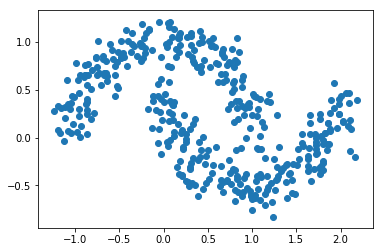

In [15]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [16]:
sess = tf.InteractiveSession()

In [17]:
tf.global_variables_initializer().run()

In [18]:
logj.eval({inp:X}).mean()

0.019804349

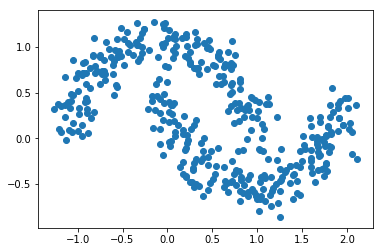

In [19]:
ver = z.eval({inp:X})
plt.scatter(ver[:,0], ver[:,1])
plt.show()

In [22]:
for _ in range(80):
    for _ in range(1000):
        train_op.run({inp:X})
    print(gain.eval({inp:X}).mean())

0.34437
0.344503
0.344633
0.34476
0.344906
0.344966
0.345094
0.345237
0.345349


KeyboardInterrupt: 

In [23]:
inverse = flows.apply(inp, inverse=True)

In [24]:
restored = inverse.eval({inp:np.random.normal(size=[400,2])})
#restored = inverse.eval({inp:ver})

In [25]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

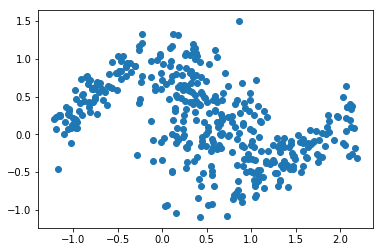

In [26]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()